In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import shuffle
import utils
import shutil
import pickle
import custom_model
import glob
import pandas as pd
import numpy as np
import itertools, os
from tqdm import tqdm
from scipy.stats import pearsonr

2024-01-22 04:25:29.696746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cell_lines = [4824, 5110, 5111]
cell_line_names = ['PC-3', 'GM12878', 'K562']
bin_index = [447, 448]
model_name = 'enformer'
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/context/')

In [3]:
summary_combined = pd.read_csv('../results/summary_csvs/enformer/context_dependence_test.csv')

In [4]:
N_per_category = []
for k, df in summary_combined.groupby('cell_line'):  # per cell line
    context_df = df[(df['context'] != 'other') & (df['context'] != 'other1')]  # remove unclassified contexts
    for context_type, one_context_df in context_df.groupby('context'):
        N = one_context_df.shape[0]
        if N > 200:
            N_after = 200
        else:
            N_after = N
        N_per_category.append([k, context_type, N, N_after])

In [5]:
N_per_category = pd.DataFrame(N_per_category, columns=["cell line", "context category", "Number of contexts", "Number of contexts after sampling"])
N_per_category

,cell line,context category,Number of contexts,Number of contexts after sampling
0,GM12878,enhancing,409,200
1,GM12878,neutral,183,183
2,GM12878,silencing,78,78
3,K562,enhancing,482,200
4,K562,neutral,295,200
5,K562,silencing,318,200
6,PC-3,enhancing,524,200
7,PC-3,neutral,110,110
8,PC-3,silencing,90,90


In [10]:
N_per_category.to_csv('../results/summary_csvs/enformer/N_seqs_per_context_category.csv')

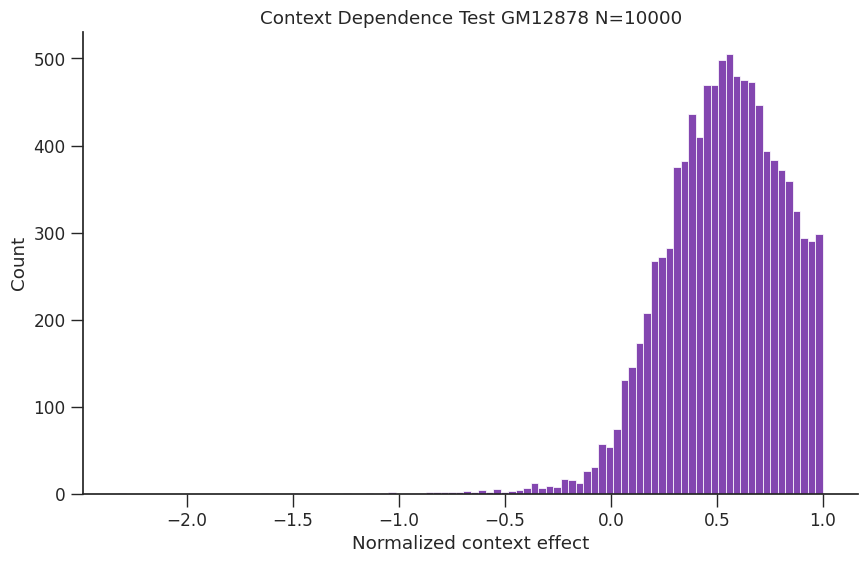

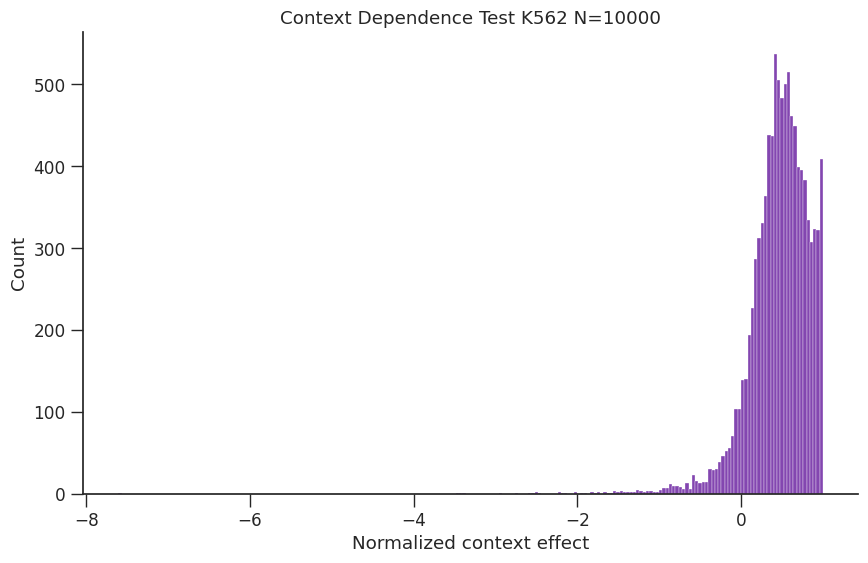

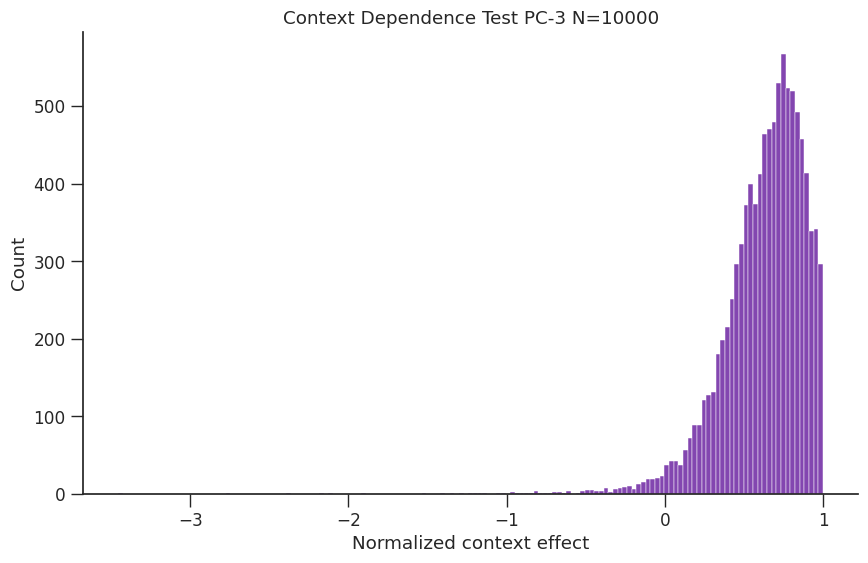

In [6]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in summary_combined.groupby('cell_line'):
    
    fig = plt.figure(figsize=[10, 6])
    ax = sns.histplot(x=df['delta_mean'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized context effect') # (WT - M) / WT
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [12]:
df

,Unnamed: 0,delta_mean,path,wt,std,mean_mut,seq_id,context,cell_line
0,0,0.477846,../results//context_dependence_test_100/enform...,14.784366,2.222776,7.719713,XPO5_chr6_43576038_-,other,PC-3
1,1,0.927049,../results//context_dependence_test_100/enform...,14.783938,0.652025,1.078504,UPK2_chr11_118956297_+,other,PC-3
2,2,0.879795,../results//context_dependence_test_100/enform...,14.816709,1.007191,1.781050,PLEKHB1_chr11_73647625_+,other,PC-3
3,3,-1.282113,../results//context_dependence_test_100/enform...,14.803543,6.064398,33.783363,ZNF606_chr19_58002819_-,silencing,PC-3
4,4,0.871365,../results//context_dependence_test_100/enform...,14.812580,1.361411,1.905413,SLC25A30_chr13_45418373_-,other,PC-3
...,...,...,...,...,...,...,...,...,...
9995,9995,0.696849,../results//context_dependence_test_100/enform...,447.238680,36.277294,135.580690,CCT3_chr1_156338257_-,other,PC-3
9996,9996,0.673640,../results//context_dependence_test_100/enform...,449.256040,28.989002,146.619230,MDH2_chr7_76048105_+,other,PC-3
9997,9997,0.550541,../results//context_dependence_test_100/enform...,451.634580,31.148926,202.991270,HSP90B1_chr12_103930409_+,other,PC-3
9998,9998,0.529612,../results//context_dependence_test_100/enform...,454.693760,20.745981,213.882630,ITGB1_chr10_32958230_-,other,PC-3


<Axes: xlabel='wt', ylabel='delta_mean'>

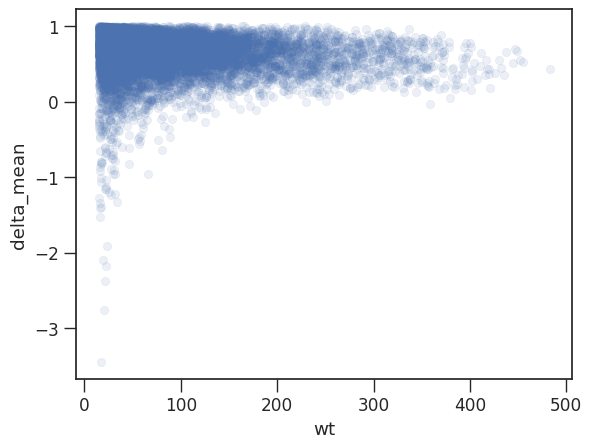

In [14]:
sns.scatterplot(data=df, x='wt', y='delta_mean', alpha=0.1, edgecolor=None)

['enhancing (N=200)', 'neutral (N=110)', 'silencing (N=90)']
['enhancing (N=200)', 'neutral (N=183)', 'silencing (N=78)']
['enhancing (N=200)', 'neutral (N=200)', 'silencing (N=200)']


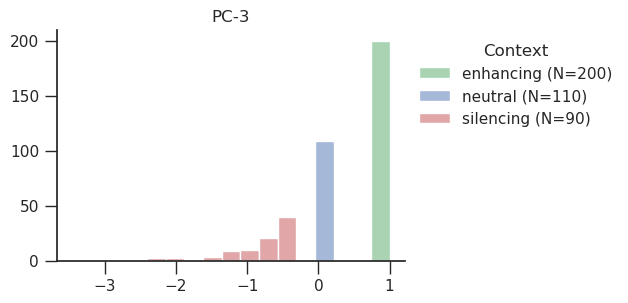

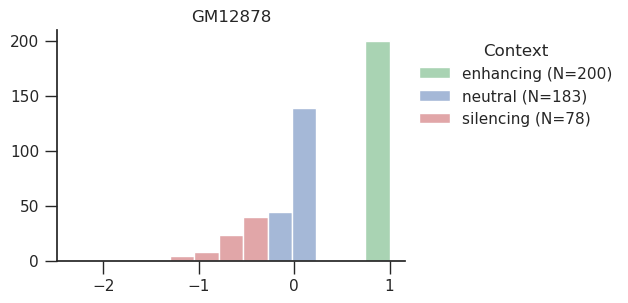

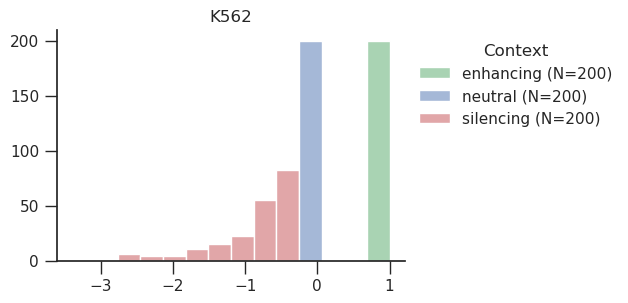

In [24]:

for k in cell_line_names:
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = pd.read_csv(f'../results/summary_csvs/enformer/{k}_selected_contexts.csv').sort_values('context')


    ax = sns.histplot(data=context_df, 
                      x='delta_mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)

    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')


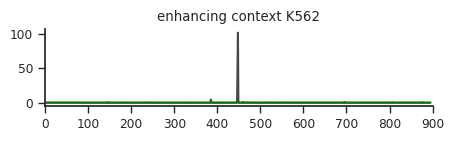

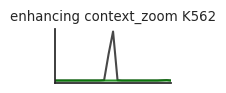

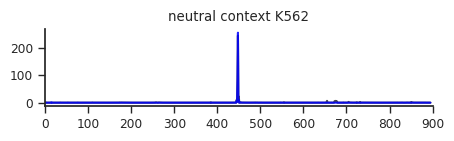

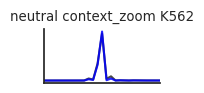

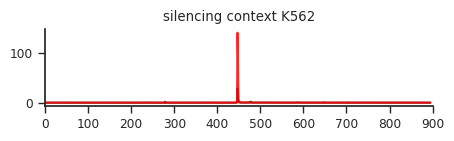

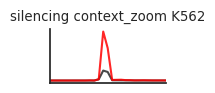

In [8]:
k = 'K562'
df = pd.read_csv(f'../results/summary_csvs/enformer/{k}_selected_contexts.csv').sort_values('context')
cell_pred_index = cell_line_names.index(k)

# select most illustrative cases

for name, color, selected_point in zip(['enhancing context', 'neutral context', 'silencing context'],
                                ['green', 'blue', 'red'],
                                [df[df['context']=='enhancing'].sort_values('delta_mean')['path'].values[-1],
                                 df[df['context']=='neutral']['path'].values[0],
                                 df[df['context']=='silencing'].sort_values('delta_mean')['path'].values[0]
                                 ]):
    with open(selected_point, 'rb') as handle:
        context_res = pickle.load(handle)
    wt = context_res['wt'][:, cell_pred_index]
    mut = context_res['mut'][:, cell_pred_index]
    for zoom in [None, [425, 475]]:
        if zoom:
            fig = plt.figure(figsize=[1.5, .7])
            name = name + '_zoom'
        else:
            fig = plt.figure(figsize=[5, 1])
            
        sns.set(font_scale = .8)
    
        sns.set_style(style='white')
        plt.rcParams['xtick.major.size'] = 5
        plt.rcParams['xtick.major.width'] = 1
    
        plt.rcParams['ytick.major.size'] = 5
        plt.rcParams['ytick.major.width'] = 1
        plt.rcParams['xtick.bottom'] = True
        plt.rcParams['ytick.left'] = True
    
        plt.plot(wt, 'k', alpha=0.8)
        plt.plot(mut, color=color, alpha=0.85)
        plt.xlim(0, 900)
        
        if zoom is None:
            if k == 'strong':
                plt.ylabel('TSS activity')
            if k == 'repressing CRE':
                plt.xlabel('Binned positions (128 nt)')
                
        if zoom:
            sns.set(font_scale = .8)
            plt.xticks([])
            plt.yticks([])
            plt.xlim(435, 461)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.title(f'{name} {k}')
        plt.show()
        fig.savefig(f'{pdf_dir}/{model_name}_{k}_{name}.pdf', format='pdf', dpi=300, bbox_inches='tight')


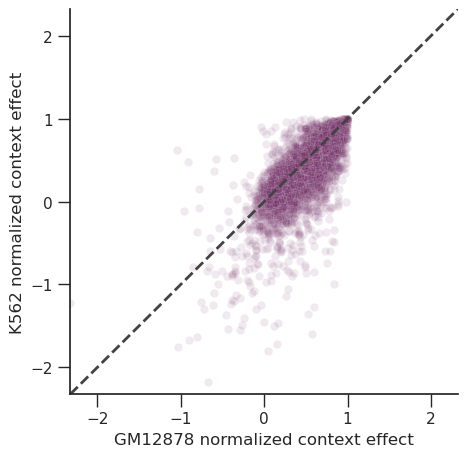

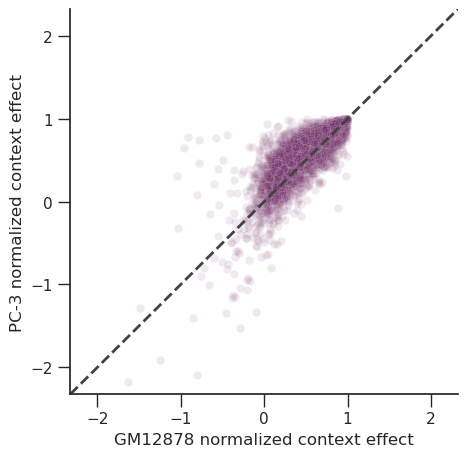

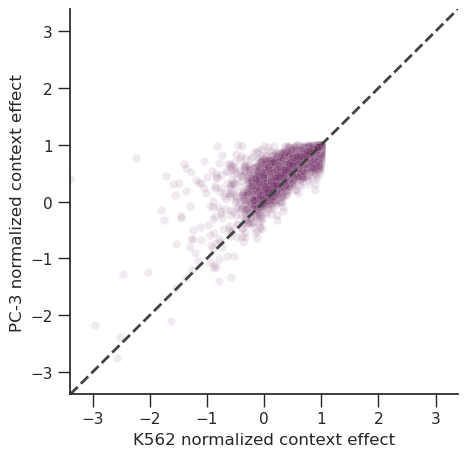

In [28]:
sns.set(font_scale = 1.)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

for (c1, df1), (c2, df2) in list(itertools.combinations([[c, df] for c, df  in summary_combined.groupby('cell_line')], 2)):
    fig = plt.figure(figsize=[5, 5])

    diff_comp = df1.merge(df2, on='seq_id', suffixes=[f'_{c1}', f'_{c2}'])
    ax=sns.scatterplot(data=diff_comp, x=f'delta_mean_{c1}', y=f'delta_mean_{c2}', edgecolors=None, color='#702963', alpha=0.1)
    min_point = np.array(diff_comp[f'delta_mean_{c1}'], diff_comp[f'delta_mean_{c2}']).min()
    # add y=x line
    plt.plot([min_point,-min_point],[min_point,-min_point], lw=2, color='#414242', linestyle='dashed')
    plt.xlabel(f'{c1} normalized context effect')
    plt.ylabel(f'{c2} normalized context effect')
    plt.xlim(min_point,-min_point)
    plt.ylim(min_point,-min_point)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()